In [4]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *

# Load data files
ml = LoadML(os.path.join(DATAPATH, "simulations", "tree_maxlik.tab"), 
            os.path.join(DATAPATH, "simulations", "tree_truth.bed"), 
            os.path.join(DATAPATH, "simulations", "tree_strsd.bed"))

#PlotSimulations([ml], estcolors=["gray"], outfile=os.path.join(PLOTDIR, "Figure2_simulations_perlocus.pdf"))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# 2A: simulations per locus

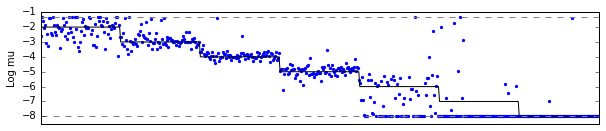

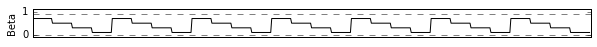

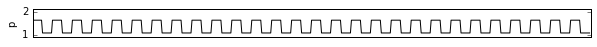

In [27]:
paramcolor = "black"
ml = ml.sort(columns=["mu","beta","strsd"], ascending=False)
order = range(ml.shape[0])
fig = plt.figure()
fig.set_size_inches((10,2))
# mu
ax = fig.add_subplot(1, 1, 1)
ax.plot(order, np.log10(ml.mu), color=paramcolor, linewidth=1)
ax.scatter(order, ml["log_estmu"], color="blue", s=5)
ax.axhline(-8, linestyle="dashed", color="gray")
ax.axhline(np.log10(0.05), linestyle="dashed", color="gray")
ax.set_ylabel("Log mu")
ax.set_xticks([])
ax.set_xlim(left=0, right=len(order))
ax.set_ylim(bottom=-8.5, top=-1.5)
ax.set_yticks(range(-8,0))
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_perlocus_mu.pdf"))

# beta
fig = plt.figure()
fig.set_size_inches((10,0.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(order, ml.beta, color=paramcolor, linewidth=1)
ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(0.9, linestyle="dashed", color="gray")
ax.set_ylabel("Beta")
ax.set_xticks([])
ax.set_xlim(left=0, right=len(order))
ax.set_ylim(bottom=-0.1, top=1.1)
ax.set_yticks([0,1])
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_perlocus_beta.pdf"))

# strsd
fig = plt.figure()
fig.set_size_inches((10,0.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(order, ml.strsd, color=paramcolor, linewidth=1)
ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(0.9, linestyle="dashed", color="gray")
ax.set_ylabel("p")
ax.set_xticks([])
ax.set_xlim(left=0, right=len(order))
ax.set_ylim(bottom=0.9, top=2.1)
ax.set_yticks([1,2]);
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_perlocus_strsd.pdf"))

# 2A: joint simulations

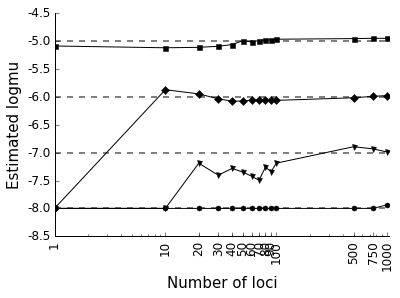

In [31]:
joint = pd.read_csv(os.path.join(DATAPATH,"simulations", "joint_estimates.tab"), sep=" ",
                    names=["logmu","beta","strsd","n","logmu_est","logmu_est_stderr","nn"])

# For each true mu, plot est vs. n
fig = plt.figure()
fig.set_size_inches((6,4))
ax = fig.add_subplot(111)
markers = ["o","v","D","s"]
cind = 0
for tm in set(joint.logmu):
    ax.axhline(tm, linestyle="dashed", color="gray", linewidth=2)
    vals = joint[joint.logmu == tm]
    vals = vals.sort("n")
    ax.semilogx(vals.n, vals.logmu_est, color="black", linewidth=1, marker=markers[cind], markersize=5)
    cind += 1
ax.set_ylim(bottom=-8.5, top=-4.5)
ax.set_xlim(left=9, right=1050)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(list(set(joint.n)))
ax.set_xticklabels(map(int, ax.get_xticks()), size=12, rotation=90)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_xlabel("Number of loci", size=15)
ax.set_ylabel("Estimated logmu", size=15)
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_joint.pdf"))